In [21]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt 
import random

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.optimizers import Adam

# Check TensorFlow version and GPU availability
print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"OpenCV Version: {cv2.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow Version: 2.16.2
NumPy Version: 1.26.4
Pandas Version: 2.2.3
OpenCV Version: 4.11.0
Num GPUs Available: 1


### --- PARAMETRI ---

In [22]:
IMG_SIZE = (224, 224) # Velikost slik za model
NUM_CLASSES = 1       # 1 izhodni nevron za binarno klasifikacijo (sigmoid)
BATCH_SIZE = 32       # Velikost serije za treniranje
NUM_EPOCHS = 10

### --- NOVE POTI DO PRIPRAVLJENIH PODATKOV (augmented train, original val/test) ---

In [23]:
TRAIN_DIR = '../data/persons/oseba_1/final_dataset_for_training/train'
VAL_DIR = '../data/persons/oseba_1/final_dataset_for_training/val'
TEST_DIR = '../data/persons/oseba_1/final_dataset_for_training/test'

# Preverimo, ali mape obstajajo
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Mapa '{TRAIN_DIR}' ne obstaja. Preverite pot ali izvedite prejšnji skript za pripravo podatkov.")
if not os.path.exists(VAL_DIR):
    raise FileNotFoundError(f"Mapa '{VAL_DIR}' ne obstaja. Preverite pot ali izvedite prejšnji skript za pripravo podatkov.")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Mapa '{TEST_DIR}' ne obstaja. Preverite pot ali izvedite prejšnji skript za pripravo podatkov.")

### PRIPRAVA TF.DATA.DATASET OBJEKTOV

In [24]:
print("\n--- PRIPRAVA TF.DATA.DATASET OBJEKTOV S 'image_dataset_from_directory' ---")

# Dataset za treniranje (augmented + original)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='binary', # Za binarno klasifikacijo (0 ali 1)
    image_size=IMG_SIZE,
    interpolation='bilinear', # Lahko je tudi 'nearest' ali 'lanczos3'
    batch_size=BATCH_SIZE,
    shuffle=True, # Premešaj podatke za treniranje
    seed=42 # Za ponovljivost shufflanja
)

# Dataset za validacijo (original)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=False # Ne rabiš mešati validacijskih podatkov
)

# Dataset za testiranje (original)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=False # Ne rabiš mešati testnih podatkov
)

# Optimizacija performance (prefetching)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print(f"Pripravljeni dataseti:")
print(f"  Učna množica: {train_dataset.cardinality().numpy() * BATCH_SIZE if train_dataset.cardinality().numpy() != tf.data.INFINITE_CARDINALITY else 'N/A'} slik")
print(f"  Validacijska množica: {val_dataset.cardinality().numpy() * BATCH_SIZE if val_dataset.cardinality().numpy() != tf.data.INFINITE_CARDINALITY else 'N/A'} slik")
print(f"  Testna množica: {test_dataset.cardinality().numpy() * BATCH_SIZE if test_dataset.cardinality().numpy() != tf.data.INFINITE_CARDINALITY else 'N/A'} slik")


--- PRIPRAVA TF.DATA.DATASET OBJEKTOV S 'image_dataset_from_directory' ---
Found 795 files belonging to 2 classes.
Found 34 files belonging to 2 classes.
Found 35 files belonging to 2 classes.
Pripravljeni dataseti:
  Učna množica: 800 slik
  Validacijska množica: 64 slik
  Testna množica: 64 slik


### --- GRADNJA IN TREINIRANJE MODELA 1: MobileNetV2 ---

In [25]:
print("\n--- GRADNJA IN TREINIRANJE MODELA: MobileNetV2 ---")

# Hiperparametri modela
MobileNetV2_DENSE = 32
MobileNetV2_Dropout = 0.4
MobileNetV2_learning_rate = 0.0001
MobileNetV2_NUM_EPOCHS=20

try:
    base_model_mobilenet = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model_mobilenet.trainable = False

    inputs_mobilenet = tf.keras.Input(shape=IMG_SIZE + (3,))
    x_mobilenet = tf.keras.applications.mobilenet_v2.preprocess_input(inputs_mobilenet)
    x_mobilenet = base_model_mobilenet(x_mobilenet)
    x_mobilenet = tf.keras.layers.GlobalAveragePooling2D()(x_mobilenet)
    x_mobilenet = tf.keras.layers.Dense(MobileNetV2_DENSE, activation='gelu')(x_mobilenet)
    x_mobilenet = tf.keras.layers.Dropout(MobileNetV2_Dropout)(x_mobilenet)
    outputs_mobilenet = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x_mobilenet)

    model_mobilenet = tf.keras.Model(inputs=inputs_mobilenet, outputs=outputs_mobilenet, name="MobileNetV2_Classifier")

    model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=MobileNetV2_learning_rate),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

    model_mobilenet.summary()

    callbacks_mobilenet = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ModelCheckpoint(filepath='best_mobilenet_model.keras', monitor='val_loss', save_best_only=True) # Dodan save_best_only
    ]

    print("\nZačenjam treniranje MobileNetV2...")
    history_mobilenet = model_mobilenet.fit(
        train_dataset,
        epochs=MobileNetV2_NUM_EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_mobilenet
    )
    print("\nTreniranje MobileNetV2 zaključeno.")

except Exception as e:
    print(f"\nPrišlo je do napake pri MobileNetV2: {e}")
    history_mobilenet = None


--- GRADNJA IN TREINIRANJE MODELA: MobileNetV2 ---


Model: "MobileNetV2_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,299,009 (8.77 MB)

 Trainable params: 41,025 (160.25 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Začenjam treniranje MobileNetV2...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.5223 - loss: 0.7554 - val_accuracy: 0.9118 - val_loss: 0.4212
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8516 - loss: 0.4254 - val_accuracy: 1.0000 - val_loss: 0.2536
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9364 - loss: 0.2823 - val_accuracy: 1.0000 - val_loss: 0.1482
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9515 - loss: 0.2049 - val_accuracy: 1.0000 - val_loss: 0.0974
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9849 - loss: 0.1428 - val_accuracy: 1.0000 - val_loss: 0.0687
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9781 - loss: 0.1042 - val_accuracy: 1.0000 - val_loss: 0.0517
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9736 - loss: 0.0980 - val_accuracy: 1.0000 - val_loss: 0.0408
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9908 - lo

### --- GRADNJA IN TREINIRANJE MODELA 2: EfficientNetV2B0 ---

In [26]:
print("\n--- GRADNJA IN TREINIRANJE MODELA: EfficientNetV2B0 ---")

# Hiperparametri modela
EfficientNetV2B0_DENSE = 16
EfficientNetV2B0_Dropout = 0.5
EfficientNetV2B0_learning_rate = 0.00005
EfficientNetV2B0_NUM_EPOCHS=50

try:
    base_model_efficientnet = tf.keras.applications.EfficientNetV2B0( # Uporabljam B0, kot je bilo v originalu
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model_efficientnet.trainable = False

    inputs_efficientnet = tf.keras.Input(shape=IMG_SIZE + (3,))
    x_efficientnet = base_model_efficientnet(inputs_efficientnet) # EfficientNetV2 ima vgrajen preprocessing
    x_efficientnet = tf.keras.layers.GlobalAveragePooling2D()(x_efficientnet)
    x_efficientnet = tf.keras.layers.Dense(EfficientNetV2B0_DENSE, activation='gelu')(x_efficientnet)
    x_efficientnet = tf.keras.layers.Dropout(EfficientNetV2B0_Dropout)(x_efficientnet)
    outputs_efficientnet = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x_efficientnet)

    model_efficientnet = tf.keras.Model(inputs=inputs_efficientnet, outputs=outputs_efficientnet, name="EfficientNetV2B0_Classifier")

    model_efficientnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=EfficientNetV2B0_learning_rate),
                               loss='binary_crossentropy',
                               metrics=['accuracy'])

    model_efficientnet.summary()

    callbacks_efficientnet = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ModelCheckpoint(filepath='best_efficientnet_b0_model.keras', monitor='val_loss', save_best_only=True)
    ]

    print("\nZačenjam treniranje EfficientNetV2B0...")
    history_efficientnet = model_efficientnet.fit(
        train_dataset,
        epochs=EfficientNetV2B0_NUM_EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_efficientnet
    )
    print("\nTreniranje EfficientNetV2B0 zaključeno.")

except Exception as e:
    print(f"\nPrišlo je do napake pri EfficientNetV2B0: {e}")
    history_efficientnet = None


--- GRADNJA IN TREINIRANJE MODELA: EfficientNetV2B0 ---


Model: "EfficientNetV2B0_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │        20,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,939,825 (22.66 MB)

 Trainable params: 20,513 (80.13 KB)

 Non-trainable params: 5,919,312 (22.58 MB)


Začenjam treniranje EfficientNetV2B0...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step - accuracy: 0.6595 - loss: 0.6416 - val_accuracy: 0.6471 - val_loss: 0.5789
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.7340 - loss: 0.5783 - val_accuracy: 0.7941 - val_loss: 0.5014
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8255 - loss: 0.4928 - val_accuracy: 0.9412 - val_loss: 0.4284
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.8950 - loss: 0.4201 - val_accuracy: 1.0000 - val_loss: 0.3622
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9457 - loss: 0.3502 - val_accuracy: 1.0000 - val_loss: 0.3030
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9269 - loss: 0.3167 - val_accuracy: 1.0000 - val_loss: 0.2557
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9402 - loss: 0.2880 - val_accuracy: 1.0000 - val_loss: 0.2185
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.955

### --- GRADNJA IN TREINIRANJE MODELA: EfficientNetV2B3 ---

In [27]:
print("\n--- GRADNJA IN TREINIRANJE MODELA: EfficientNetV2B3 ---")

# Hiperparametri modela
EfficientNetV2B3_DENSE = 32
EfficientNetV2B3_Dropout = 0.5
EfficientNetV2B3_learning_rate = 0.00005
EfficientNetV2B3_NUM_EPOCHS=50

try:
    base_model_efficientnet_b3 = tf.keras.applications.EfficientNetV2B3(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model_efficientnet_b3.trainable = False

    inputs_efficientnet_b3 = tf.keras.Input(shape=IMG_SIZE + (3,))
    x_efficientnet_b3 = base_model_efficientnet_b3(inputs_efficientnet_b3)
    x_efficientnet_b3 = tf.keras.layers.GlobalAveragePooling2D()(x_efficientnet_b3)
    x_efficientnet_b3 = tf.keras.layers.Dense(EfficientNetV2B3_DENSE, activation='gelu')(x_efficientnet_b3)
    x_efficientnet_b3 = tf.keras.layers.Dropout(EfficientNetV2B3_Dropout)(x_efficientnet_b3)
    outputs_efficientnet_b3 = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x_efficientnet_b3)

    model_efficientnet_b3 = tf.keras.Model(inputs=inputs_efficientnet_b3, outputs=outputs_efficientnet_b3, name="EfficientNetV2B3_Classifier")

    model_efficientnet_b3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=EfficientNetV2B3_learning_rate),
                                  loss='binary_crossentropy',
                                  metrics=['accuracy'])

    model_efficientnet_b3.summary()

    callbacks_efficientnet_b3 = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ModelCheckpoint(filepath='best_efficientnetv2b3_model.keras', monitor='val_loss', save_best_only=True)
    ]

    print("\nZačenjam treniranje EfficientNetV2B3...")
    history_efficientnet_b3 = model_efficientnet_b3.fit(
        train_dataset,
        epochs=EfficientNetV2B3_NUM_EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_efficientnet_b3
    )
    print("\nTreniranje EfficientNetV2B3 zaključeno.")

except Exception as e:
    print(f"\nPrišlo je do napake pri EfficientNetV2B3: {e}")
    history_efficientnet_b3 = None


--- GRADNJA IN TREINIRANJE MODELA: EfficientNetV2B3 ---


Model: "EfficientNetV2B3_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 7, 7, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │        49,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,979,839 (49.51 MB)

 Trainable params: 49,217 (192.25 KB)

 Non-trainable params: 12,930,622 (49.33 MB)


Začenjam treniranje EfficientNetV2B3...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 498ms/step - accuracy: 0.6656 - loss: 0.6042 - val_accuracy: 0.7647 - val_loss: 0.4583
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8377 - loss: 0.4524 - val_accuracy: 0.8824 - val_loss: 0.3518
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9268 - loss: 0.3555 - val_accuracy: 0.9118 - val_loss: 0.2726
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9521 - loss: 0.2806 - val_accuracy: 0.9412 - val_loss: 0.2140
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9517 - loss: 0.2357 - val_accuracy: 1.0000 - val_loss: 0.1744
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9723 - loss: 0.1864 - val_accuracy: 1.0000 - val_loss: 0.1417
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9737 - loss: 0.1604 - val_accuracy: 1.0000 - val_loss: 0.1156
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy

### --- GRADNJA IN TREINIRANJE MODELA: ResNet50V2 ---

In [28]:
print("\n--- GRADNJA IN TREINIRANJE MODELA: ResNet50V2 ---")

# Hiperparametri modela
ResNet50V2_DENSE = 32
ResNet50V2_Dropout = 0.5
ResNet50V2_learning_rate = 0.00005
ResNet50V2_NUM_EPOCHS=50

try:
    base_model_resnet50v2 = tf.keras.applications.ResNet50V2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model_resnet50v2.trainable = False

    inputs_resnet50v2 = tf.keras.Input(shape=IMG_SIZE + (3,))
    x_resnet50v2 = tf.keras.applications.resnet_v2.preprocess_input(inputs_resnet50v2)
    x_resnet50v2 = base_model_resnet50v2(x_resnet50v2)
    x_resnet50v2 = tf.keras.layers.GlobalAveragePooling2D()(x_resnet50v2)
    x_resnet50v2 = tf.keras.layers.Dense(ResNet50V2_DENSE, activation='gelu')(x_resnet50v2)
    x_resnet50v2 = tf.keras.layers.Dropout(ResNet50V2_Dropout)(x_resnet50v2)
    outputs_resnet50v2 = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x_resnet50v2)

    model_resnet50v2 = tf.keras.Model(inputs=inputs_resnet50v2, outputs=outputs_resnet50v2, name="ResNet50V2_Classifier")

    model_resnet50v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ResNet50V2_learning_rate),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    model_resnet50v2.summary()

    callbacks_resnet50v2 = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ModelCheckpoint(filepath='best_resnet50v2_model.keras', monitor='val_loss', save_best_only=True)
    ]

    print("\nZačenjam treniranje ResNet50V2...")
    history_resnet50v2 = model_resnet50v2.fit(
        train_dataset,
        epochs=ResNet50V2_NUM_EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_resnet50v2
    )
    print("\nTreniranje ResNet50V2 zaključeno.")

except Exception as e:
    print(f"\nPrišlo je do napake pri ResNet50V2: {e}")
    history_resnet50v2 = None


--- GRADNJA IN TREINIRANJE MODELA: ResNet50V2 ---


Model: "ResNet50V2_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,630,401 (90.14 MB)

 Trainable params: 65,601 (256.25 KB)

 Non-trainable params: 23,564,800 (89.89 MB)


Začenjam treniranje ResNet50V2...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/step - accuracy: 0.6321 - loss: 0.6183 - val_accuracy: 0.8824 - val_loss: 0.3969
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.7820 - loss: 0.4431 - val_accuracy: 0.9412 - val_loss: 0.2987
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8791 - loss: 0.3243 - val_accuracy: 0.9412 - val_loss: 0.2295
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9145 - loss: 0.2749 - val_accuracy: 0.9706 - val_loss: 0.1797
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9459 - loss: 0.2154 - val_accuracy: 1.0000 - val_loss: 0.1426
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9563 - loss: 0.1700 - val_accuracy: 1.0000 - val_loss: 0.1171
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9582 - loss: 0.1496 - val_accuracy: 1.0000 - val_loss: 0.0987
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9826 

### --- OCENJEVANJE MODELOV NA TESTNI MNOŽICI ---

In [29]:
print("\n--- OCENJEVANJE MODELOV NA TESTNI MNOŽICI ---")

if history_mobilenet is not None:
    print("\nOcenjevanje MobileNetV2 na testni množici:")
    loss_mobilenet, acc_mobilenet = model_mobilenet.evaluate(test_dataset)
    print(f"MobileNetV2 - Testna izguba: {loss_mobilenet:.4f}, Testna natančnost: {acc_mobilenet:.4f}")
else:
    print("\nMobileNetV2 ni bil treniran zaradi napake.")
    loss_mobilenet, acc_mobilenet = None, None

if history_efficientnet is not None:
    print("\nOcenjevanje EfficientNetV2B0 na testni množici:")
    loss_efficientnet, acc_efficientnet = model_efficientnet.evaluate(test_dataset)
    print(f"EfficientNetV2B0 - Testna izguba: {loss_efficientnet:.4f}, Testna natančnost: {acc_efficientnet:.4f}")
else:
    print("\nEfficientNetV2B0 ni bil treniran zaradi napake.")
    loss_efficientnet, acc_efficientnet = None, None

if history_efficientnet_b3 is not None:
    print("\nOcenjevanje EfficientNetV2B3 na testni množici:")
    loss_efficientnet_b3, acc_efficientnet_b3 = model_efficientnet_b3.evaluate(test_dataset)
    print(f"EfficientNetV2B3 - Testna izguba: {loss_efficientnet_b3:.4f}, Testna natančnost: {acc_efficientnet_b3:.4f}")
else:
    print("\nEfficientNetV2B3 ni bil treniran zaradi napake.")
    loss_efficientnet_b3, acc_efficientnet_b3 = None, None

if history_resnet50v2 is not None:
    print("\nOcenjevanje ResNet50V2 na testni množici:")
    loss_resnet50v2, acc_resnet50v2 = model_resnet50v2.evaluate(test_dataset)
    print(f"ResNet50V2 - Testna izguba: {loss_resnet50v2:.4f}, Testna natančnost: {acc_resnet50v2:.4f}")
else:
    print("\nResNet50V2 ni bil treniran zaradi napake.")
    loss_resnet50v2, acc_resnet50v2 = None, None


--- OCENJEVANJE MODELOV NA TESTNI MNOŽICI ---

Ocenjevanje MobileNetV2 na testni množici:
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step - accuracy: 1.0000 - loss: 0.0049
MobileNetV2 - Testna izguba: 0.0049, Testna natančnost: 1.0000

Ocenjevanje EfficientNetV2B0 na testni množici:
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0093
EfficientNetV2B0 - Testna izguba: 0.0091, Testna natančnost: 1.0000

Ocenjevanje EfficientNetV2B3 na testni množici:
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0021
EfficientNetV2B3 - Testna izguba: 0.0021, Testna natančnost: 1.0000

Ocenjevanje ResNet50V2 na testni množici:
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step - accuracy: 1.0000 - loss: 0.0087
ResNet50V2 - Testna izguba: 0.0086, Testna natančnost: 1.0000


### --- VIZUALIZACIJA REZULTATOV ---


--- VIZUALIZACIJA REZULTATOV ---


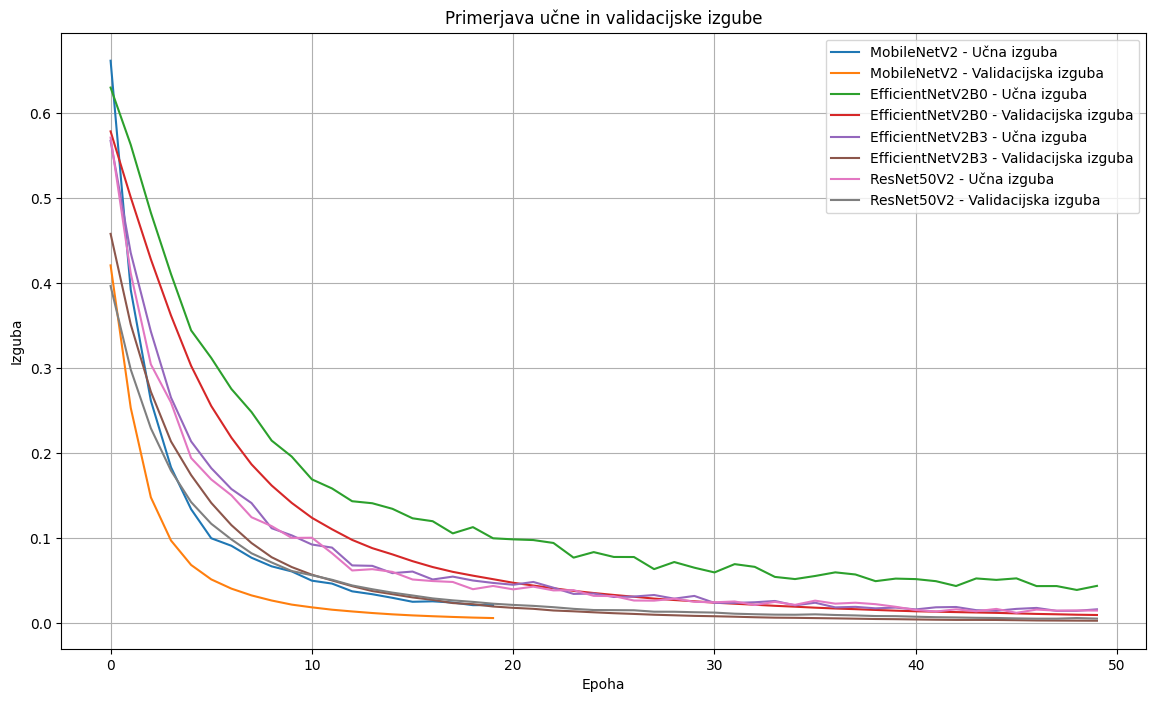

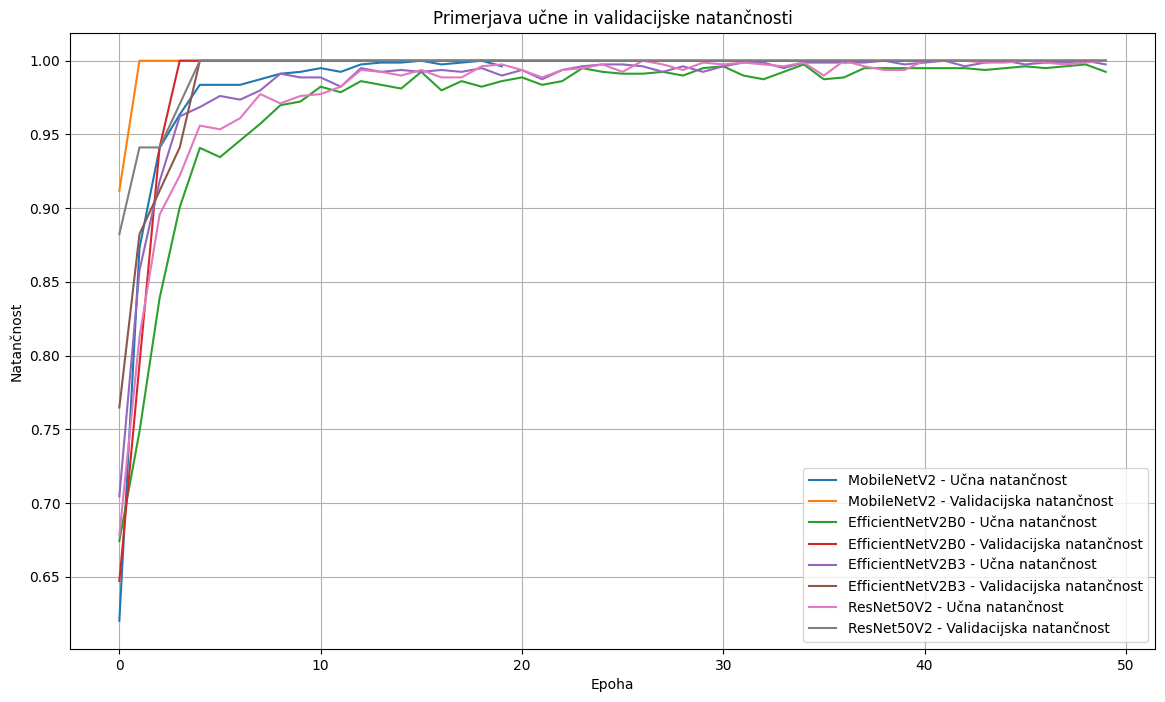


--- Povzetek končnih rezultatov na testni množici ---
           Model Testna izguba Testna natančnost
     MobileNetV2        0.0049            1.0000
EfficientNetV2B0        0.0091            1.0000
EfficientNetV2B3        0.0021            1.0000
      ResNet50V2        0.0086            1.0000


In [30]:
# ... (koda za risanje grafov in povzetek v tabeli) ...
print("\n--- VIZUALIZACIJA REZULTATOV ---")

if (history_mobilenet is not None and history_efficientnet is not None and
    history_efficientnet_b3 is not None and history_resnet50v2 is not None):

    plt.figure(figsize=(14, 8))
    plt.plot(history_mobilenet.history['loss'], label='MobileNetV2 - Učna izguba')
    plt.plot(history_mobilenet.history['val_loss'], label='MobileNetV2 - Validacijska izguba')
    plt.plot(history_efficientnet.history['loss'], label='EfficientNetV2B0 - Učna izguba')
    plt.plot(history_efficientnet.history['val_loss'], label='EfficientNetV2B0 - Validacijska izguba')
    plt.plot(history_efficientnet_b3.history['loss'], label='EfficientNetV2B3 - Učna izguba')
    plt.plot(history_efficientnet_b3.history['val_loss'], label='EfficientNetV2B3 - Validacijska izguba')
    plt.plot(history_resnet50v2.history['loss'], label='ResNet50V2 - Učna izguba')
    plt.plot(history_resnet50v2.history['val_loss'], label='ResNet50V2 - Validacijska izguba')
    plt.title('Primerjava učne in validacijske izgube')
    plt.xlabel('Epoha')
    plt.ylabel('Izguba')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 8))
    plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2 - Učna natančnost')
    plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNetV2 - Validacijska natančnost')
    plt.plot(history_efficientnet.history['accuracy'], label='EfficientNetV2B0 - Učna natančnost')
    plt.plot(history_efficientnet.history['val_accuracy'], label='EfficientNetV2B0 - Validacijska natančnost')   
    plt.plot(history_efficientnet_b3.history['accuracy'], label='EfficientNetV2B3 - Učna natančnost')
    plt.plot(history_efficientnet_b3.history['val_accuracy'], label='EfficientNetV2B3 - Validacijska natančnost')
    plt.plot(history_resnet50v2.history['accuracy'], label='ResNet50V2 - Učna natančnost')
    plt.plot(history_resnet50v2.history['val_accuracy'], label='ResNet50V2 - Validacijska natančnost')
    plt.title('Primerjava učne in validacijske natančnosti')
    plt.xlabel('Epoha')
    plt.ylabel('Natančnost')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n--- Povzetek končnih rezultatov na testni množici ---")
    results = pd.DataFrame({
        'Model': ['MobileNetV2', 'EfficientNetV2B0', 'EfficientNetV2B3', 'ResNet50V2'],
        'Testna izguba': [f'{loss_mobilenet:.4f}' if loss_mobilenet is not None else 'N/A',
                         f'{loss_efficientnet:.4f}' if loss_efficientnet is not None else 'N/A',
                         f'{loss_efficientnet_b3:.4f}' if loss_efficientnet_b3 is not None else 'N/A',
                         f'{loss_resnet50v2:.4f}' if loss_resnet50v2 is not None else 'N/A'],
        'Testna natančnost': [f'{acc_mobilenet:.4f}' if acc_mobilenet is not None else 'N/A',
                              f'{acc_efficientnet:.4f}' if acc_efficientnet is not None else 'N/A',
                              f'{acc_efficientnet_b3:.4f}' if acc_efficientnet_b3 is not None else 'N/A',
                              f'{acc_resnet50v2:.4f}' if acc_resnet50v2 is not None else 'N/A']
    })
    print(results.to_string(index=False))

else:
    print("\nVizualizacija in povzetek nista mogoča, ker vsaj en model ni bil uspešno treniran.")

### --- VIZUALIZACIJA NAPOVEDI NA TESTNI MNOŽICI ---


--- VIZUALIZACIJA NAPOVEDI NA TESTNI MNOŽICI (naključno izbranih) ---


2025-06-01 11:36:42.569325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step


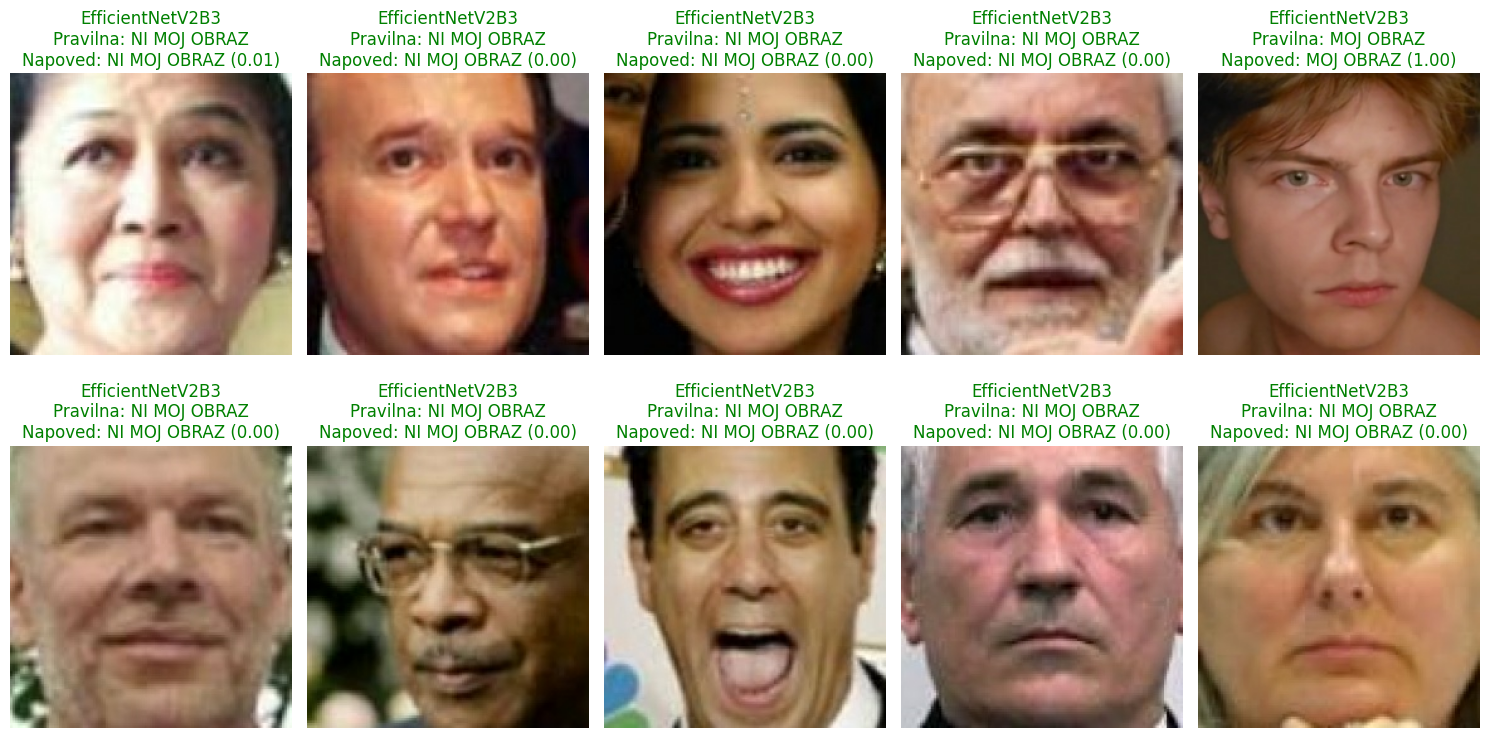

In [31]:
print("\n--- VIZUALIZACIJA NAPOVEDI NA TESTNI MNOŽICI (naključno izbranih) ---")

# Pomožna funkcija za prikaz napovedi na sliki
def plot_prediction(ax, image, true_label, predicted_prob, model_name):
    predicted_label = 1 if predicted_prob > 0.5 else 0
    
    true_label_str = "MOJ OBRAZ" if true_label == 1 else "NI MOJ OBRAZ"
    predicted_label_str = "MOJ OBRAZ" if predicted_label == 1 else "NI MOJ OBRAZ"
    
    color = "green" if true_label == predicted_label else "red"
    
    title = f"{model_name}\nPravilna: {true_label_str}\nNapoved: {predicted_label_str} ({predicted_prob:.2f})"
    
    ax.imshow(image.numpy().astype("uint8")) # Slike iz tf.data.Dataset so uint8
    ax.set_title(title, color=color)
    ax.axis('off')

# Izberemo model za vizualizacijo (npr. najboljši EfficientNetV2B3)
model_to_visualize = model_efficientnet_b3 # Spremeni na želeni model (npr. model_mobilenet)
model_to_visualize_name = "EfficientNetV2B3"

if model_to_visualize is not None:
    # Zberemo nekaj primerov iz test_dataset za vizualizacijo
    num_display_images = 10 # Koliko slik želimo prikazati
    
    # Pridobi vse slike in labele iz test_dataset
    all_test_images = []
    all_test_labels = []
    for images, labels in test_dataset.unbatch():
        all_test_images.append(images)
        all_test_labels.append(labels)
    
    # Pretvorimo v TensorFlow Tensors
    all_test_images_tensor = tf.stack(all_test_images)
    all_test_labels_tensor = tf.stack(all_test_labels)

    # Naredimo napovedi za celotno testno množico
    test_predictions = model_to_visualize.predict(test_dataset).flatten() # Pridobi verjetnosti
    
    # Izberemo naključne indekse za prikaz
    num_samples = len(all_test_images)
    random_indices = random.sample(range(num_samples), min(num_display_images, num_samples))
    
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(random_indices):
        ax = plt.subplot(2, (num_display_images + 1) // 2, i + 1) # Prilagodi postavitev
        
        image = all_test_images_tensor[idx]
        true_label = all_test_labels_tensor[idx].numpy()
        predicted_prob = test_predictions[idx]
        
        # Prikaz slike z napovedjo
        plot_prediction(ax, image, true_label, predicted_prob, model_to_visualize_name)
    
    plt.tight_layout()
    plt.show()

else:
    print(f"Model {model_to_visualize_name} ni bil treniran, zato vizualizacija ni mogoča.")

### --- FUNKCIJA ZA ZAZNAVANJE IN PREDPROCESIRANJE OBRAZA ZA SKLEPANJE ---

In [32]:
def preprocess_for_prediction_full(image_path, target_size=(224, 224), model_type='mobilenet', denoise=False):
    """
    Naloži sliko, zazna in obreže obraz ter ga predprocesira za model.
    Vrne:
    - original_img_bgr: originalna slika (BGR, [0, 255])
    - display_face_img: obrezan in pomanjšan obraz (BGR, [0, 255])
    - processed_face_for_model: procesiran obraz za model
    - bbox: koordinater obrezanega obraza (x1, y1, x2, y2) ali None, če ni obraza
    - denoise: Ali naj se izvede denoising slike pred zaznavanjem obraza
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Napaka: Slike ni mogoče naložiti iz {image_path}")
        return None, None, None, None

    original_img_bgr = img.copy() # Kopiramo originalno sliko
    
    # Dodan Denoising, če je omogočen
    if denoise:
        # Pretvori v RGB za boljše delovanje denoiserja, nato nazaj v BGR
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_denoised_rgb = cv2.fastNlMeansDenoisingColored(img_rgb, None, 10, 10, 7, 21)
        img = cv2.cvtColor(img_denoised_rgb, cv2.COLOR_RGB2BGR)


    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return original_img_bgr, None, None, None # Vrnemo originalno sliko, ostalo None
    elif len(faces) > 1:
        # Če je zaznanih več obrazov, izberemo največjega
        (x, y, w, h) = max(faces, key=lambda f: f[2] * f[3])
    else:
        (x, y, w, h) = faces[0]

    # Obreži obraz (dodamo malo roba)
    margin_x = int(w * 0.1)
    margin_y = int(h * 0.1)
    x1 = max(0, x - margin_x)
    y1 = max(0, y - margin_y)
    x2 = min(img.shape[1], x + w + margin_x)
    y2 = min(img.shape[0], y + h + margin_y)

    face_crop = img[y1:y2, x1:x2]
    face_resized = cv2.resize(face_crop, target_size)

    display_face_img = face_resized.copy() # Obraz za prikaz (BGR format, [0, 255])

    # Normalizacija in pretvorba v ustrezen tip za model
    face_processed = np.expand_dims(face_resized, axis=0).astype(np.float32) # Standardno za začetek (0-255 float32)
    
    if model_type == 'mobilenet':
        face_processed = tf.keras.applications.mobilenet_v2.preprocess_input(face_processed)
    elif model_type == 'efficientnet':
        # EfficientNetV2 ima vgrajen preprocessing, zato pustimo [0, 255] float32
        pass 
    elif model_type == 'resnet':
        face_processed = tf.keras.applications.resnet_v2.preprocess_input(face_processed)
    else:
        raise ValueError("Neznan tip modela. Uporabi 'mobilenet', 'efficientnet' ali 'resnet'.")

    return original_img_bgr, display_face_img, face_processed, (x1, y1, x2, y2)

### --- POMOŽNA FUNKCIJA ZA PRIKAZ REZULTATOV NA CELOTNI SLIKI ---

In [33]:
# Tudi to ponavljam, da je blok samostojen.
def display_full_image_prediction_multiple_models(ax, model_name, original_img_bgr, bbox, prediction_prob, image_filename):
    """Prikaže originalno sliko z zaznanim obrazom in napovedjo za posamezen model."""
    predicted_label = "MOJ OBRAZ" if prediction_prob > 0.5 else "NI MOJ OBRAZ"
    
    display_img_copy = original_img_bgr.copy() # Delamo na kopiji, da se ne risa po originalni sliki vsak model

    # Nariši pravokotnik okoli zaznanega obraza (če je bil zaznan)
    if bbox:
        x1, y1, x2, y2 = bbox
        color = (0, 255, 0) if prediction_prob > 0.5 else (0, 0, 255) # Zelena za MOJ, rdeča za NE MOJ
        cv2.rectangle(display_img_copy, (x1, y1), (x2, y2), color, 3)
        
        # Dodaj besedilo z napovedjo
        text = f"{predicted_label} ({prediction_prob:.2f})"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        font_thickness = 2
        text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
        
        # Položaj besedila nad pravokotnikom
        text_x = x1
        text_y = y1 - 10 if y1 - 10 > 10 else y2 + text_size[1] + 10 # Da ni izven slike
        
        cv2.putText(display_img_copy, text, (text_x, text_y), font, font_scale, color, font_thickness, cv2.LINE_AA)
    
    ax.imshow(cv2.cvtColor(display_img_copy, cv2.COLOR_BGR2RGB))
    ax.set_title(f"{model_name}\nNapoved: {predicted_label} ({prediction_prob:.2f})")
    ax.axis('off')

### --- TESTIRANJE NA VSEH SLIKAH V 'RAW_IMAGES_DIR' ---


--- TESTIRANJE NA VSEH SLIKAH V 'RAW_IMAGES_DIR' ---

Obdelujem sliko: LaraDoma.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


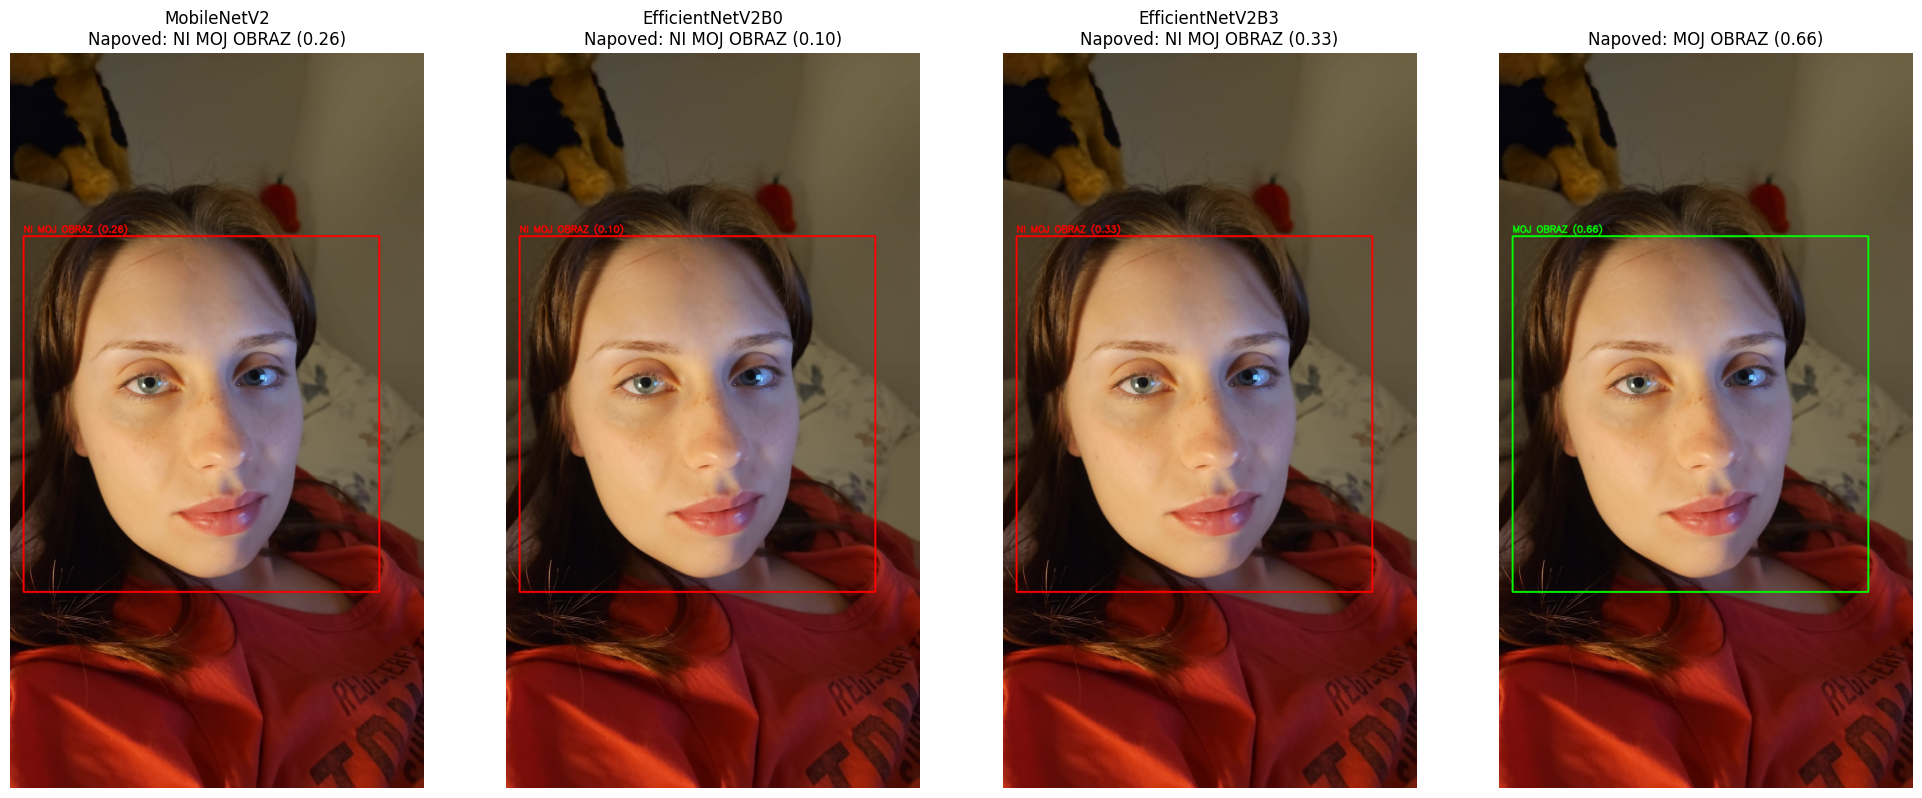


Obdelujem sliko: WhatsApp Image (8).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


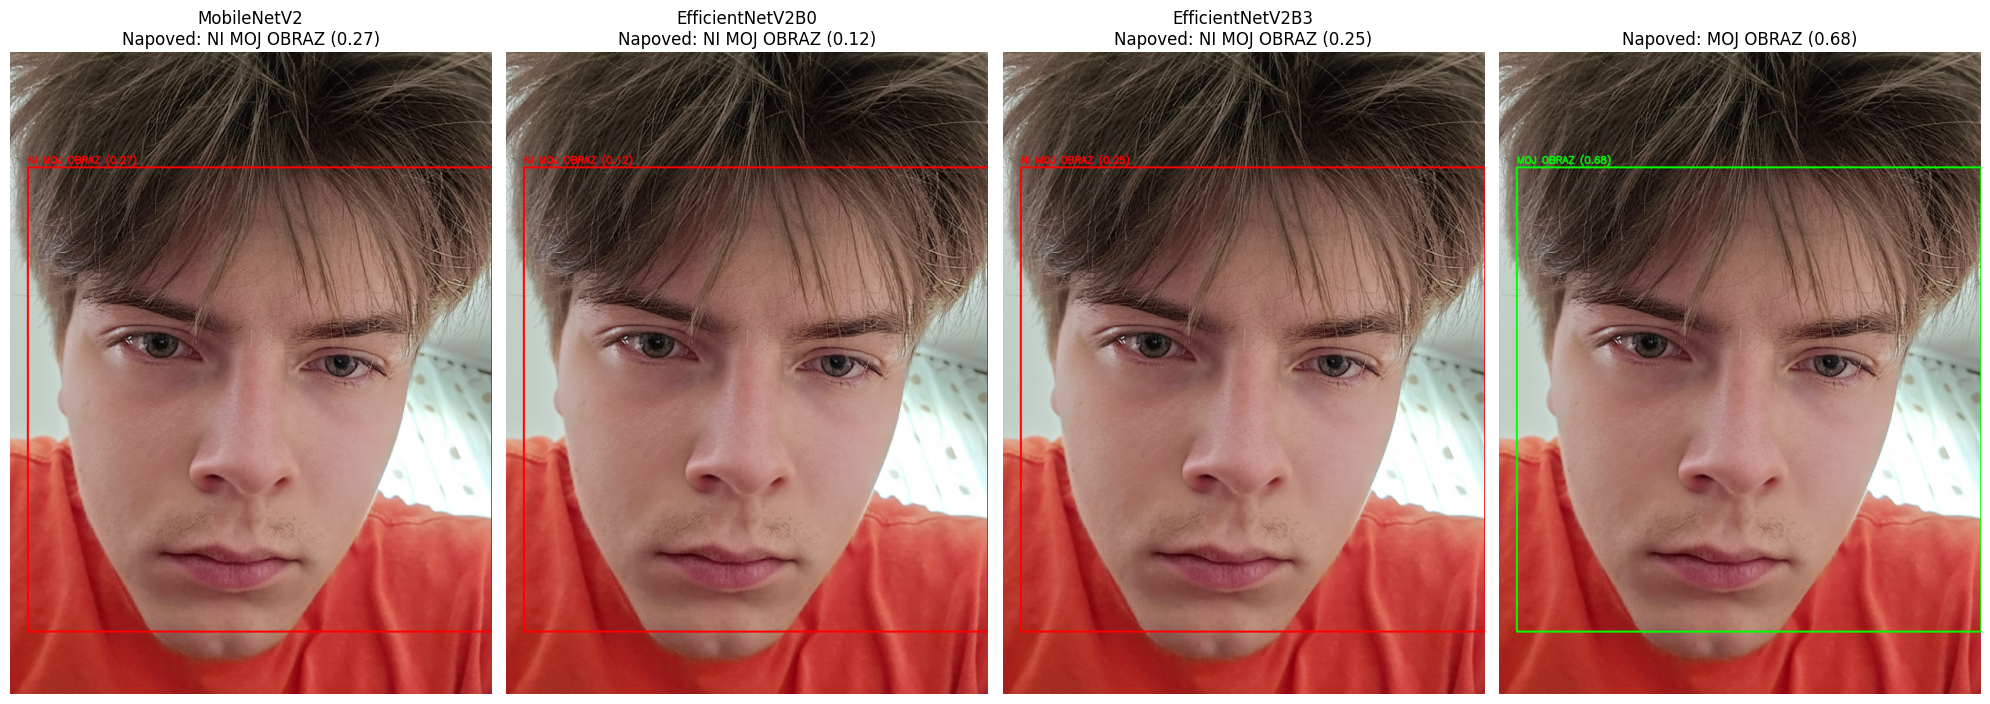


Obdelujem sliko: Image from WhatsApp (6).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


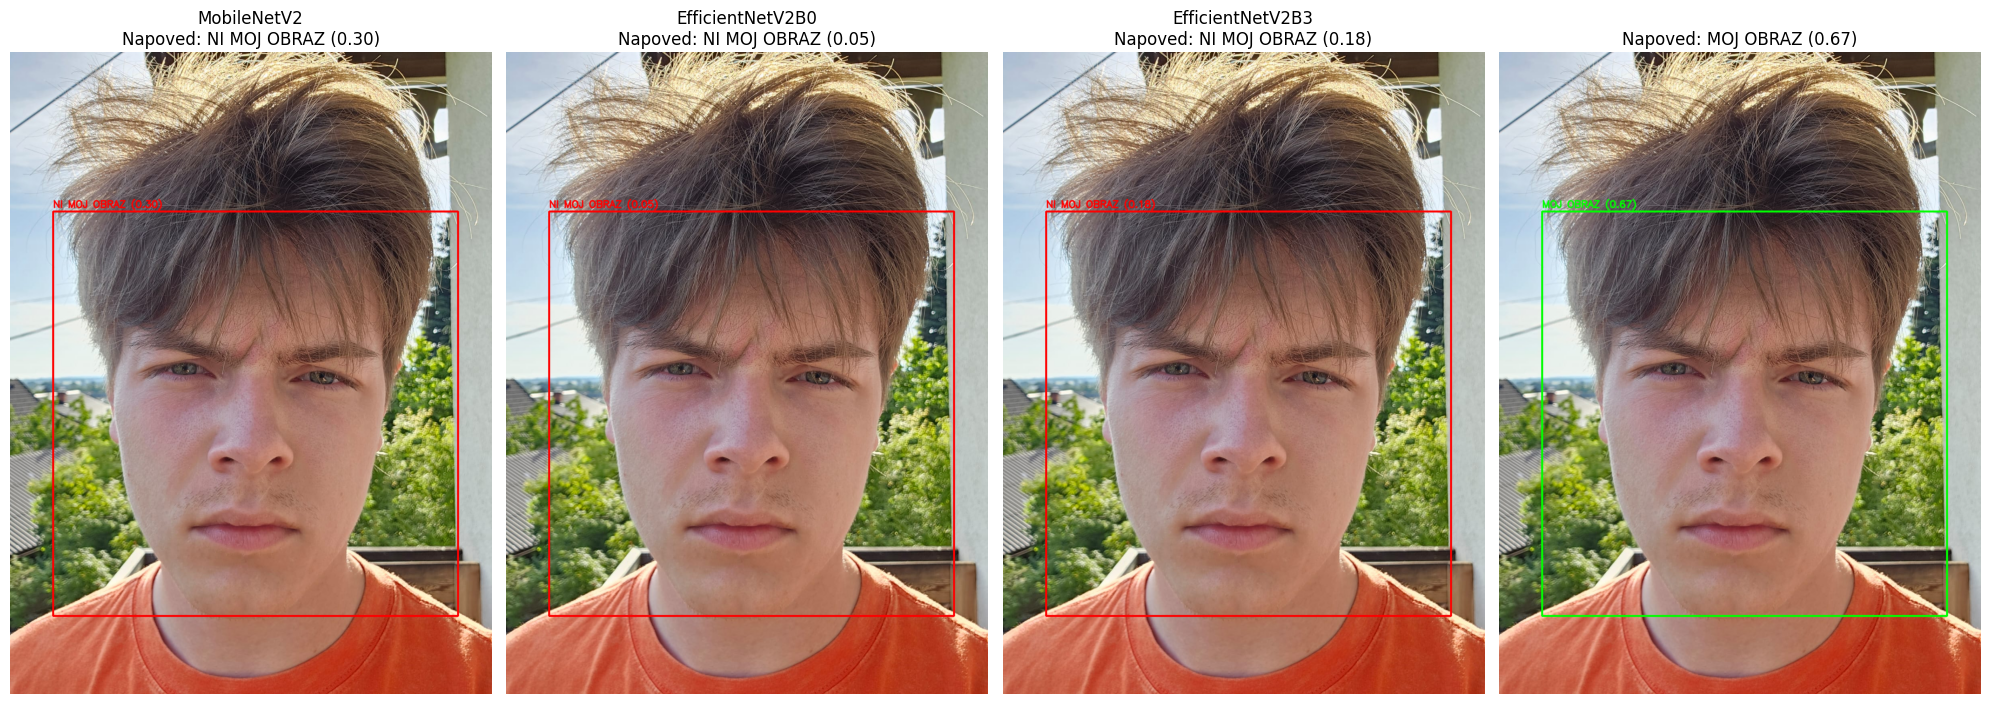


Obdelujem sliko: face_43_cleaned_frame_0215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


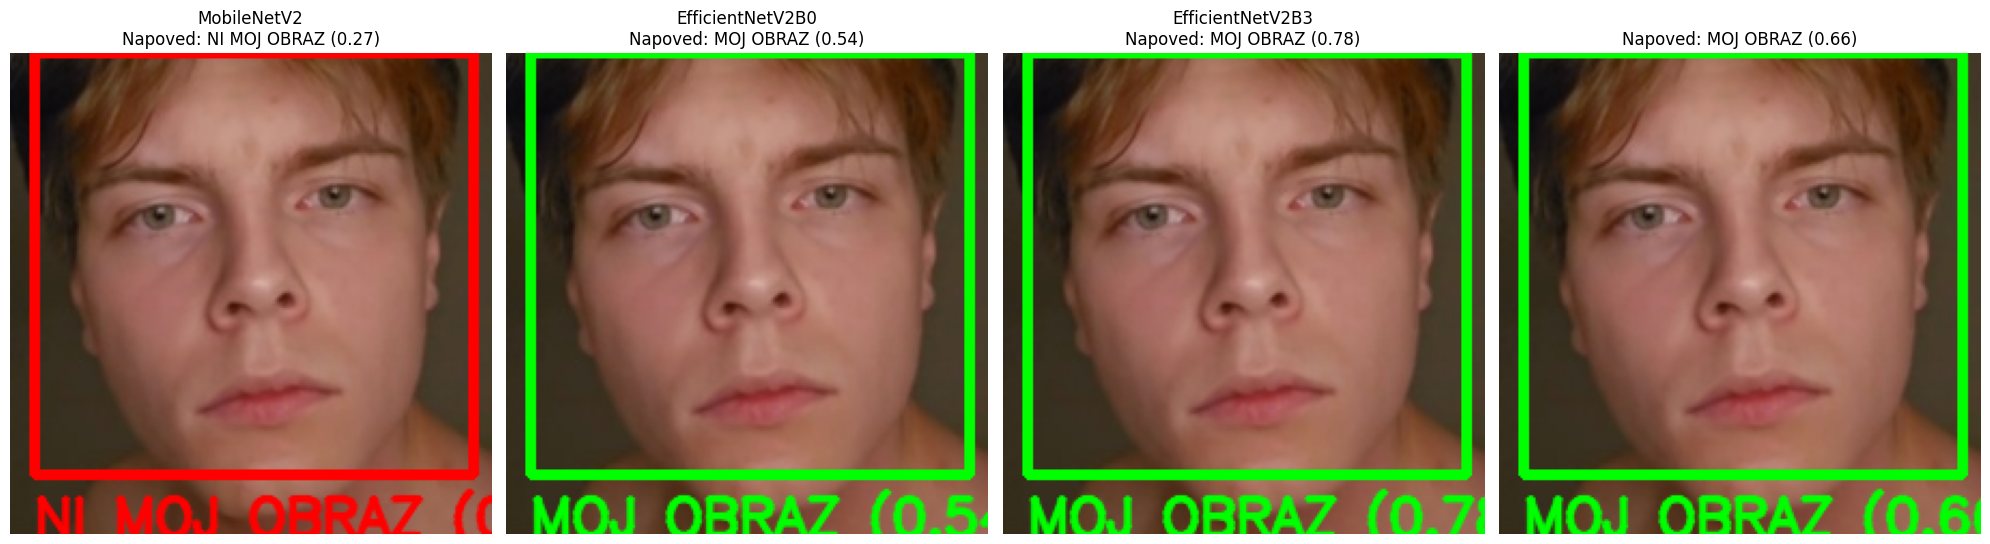


Obdelujem sliko: JostDoma.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


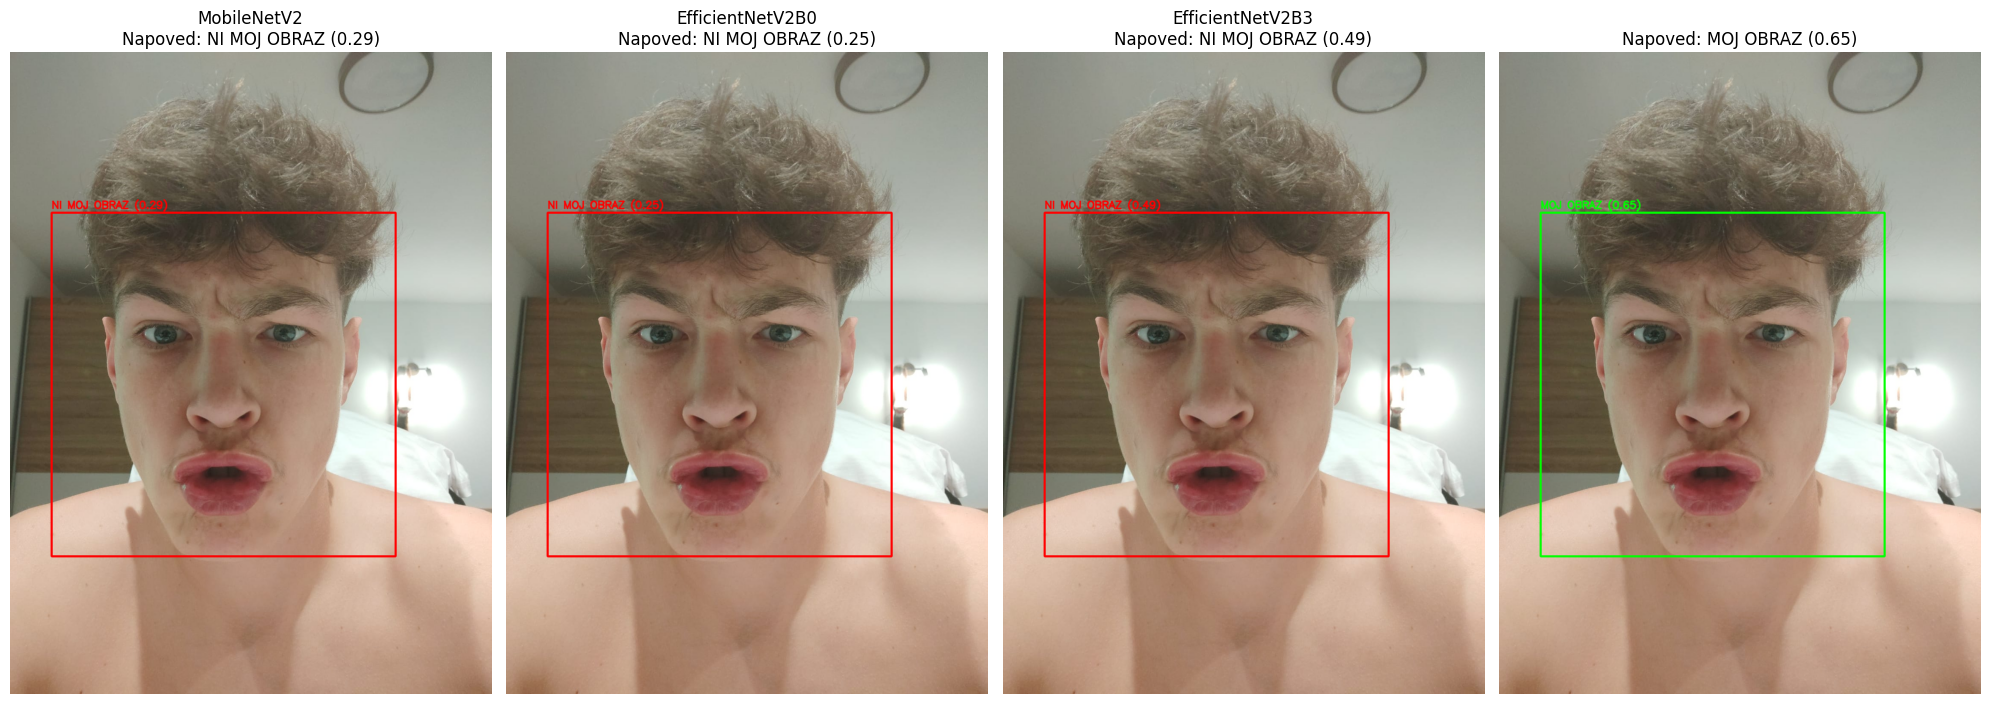


Obdelujem sliko: WhatsApp Image (9).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


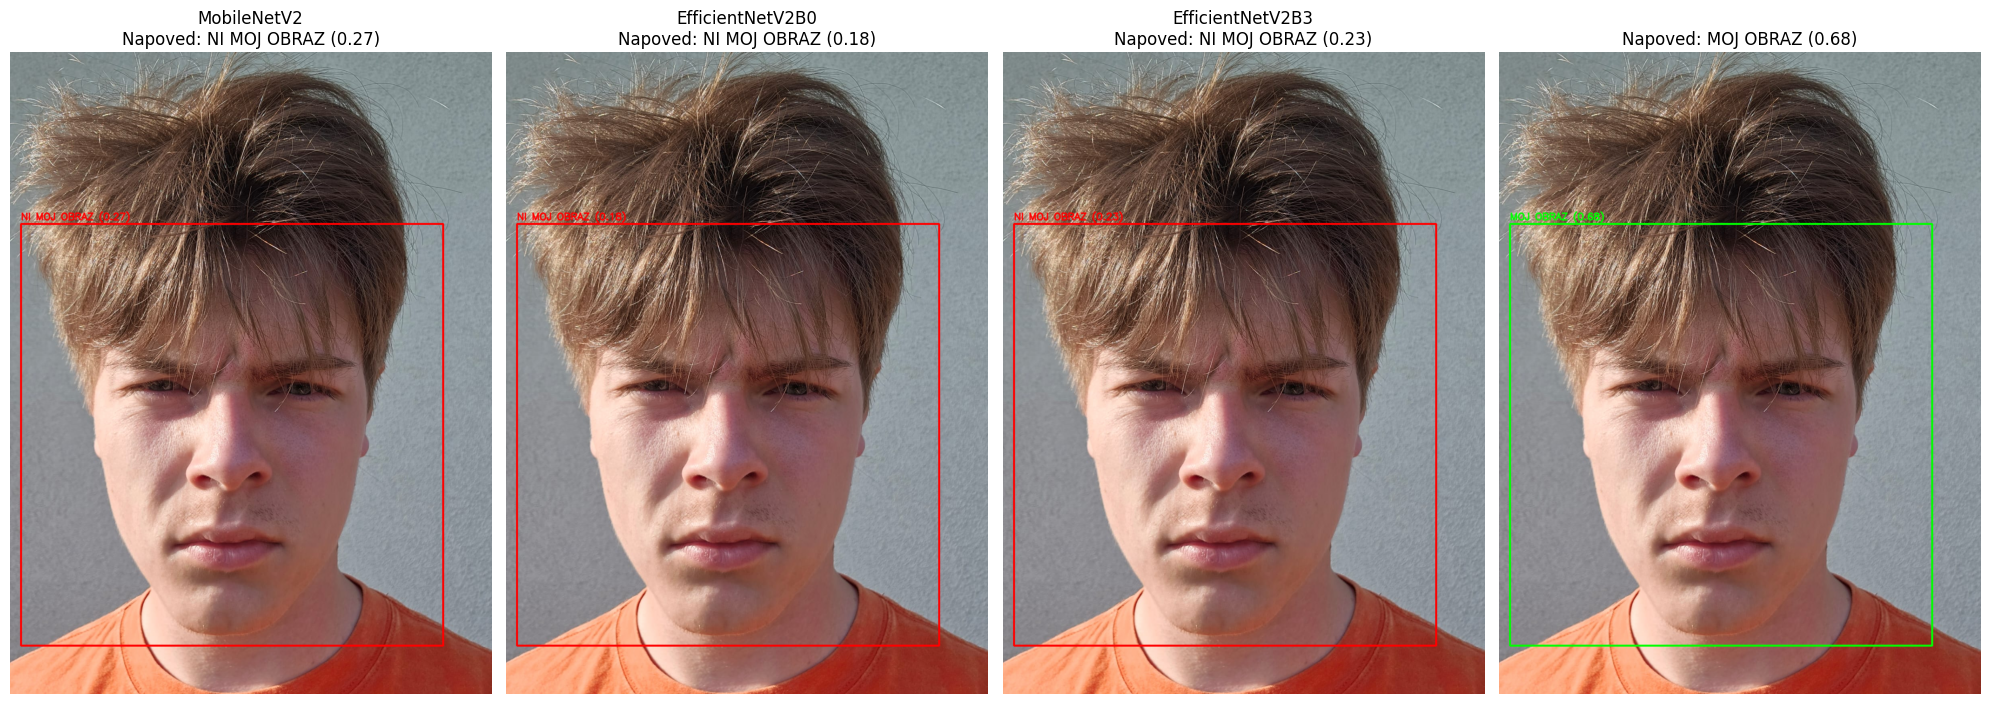


Obdelujem sliko: Image from WhatsApp (7).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


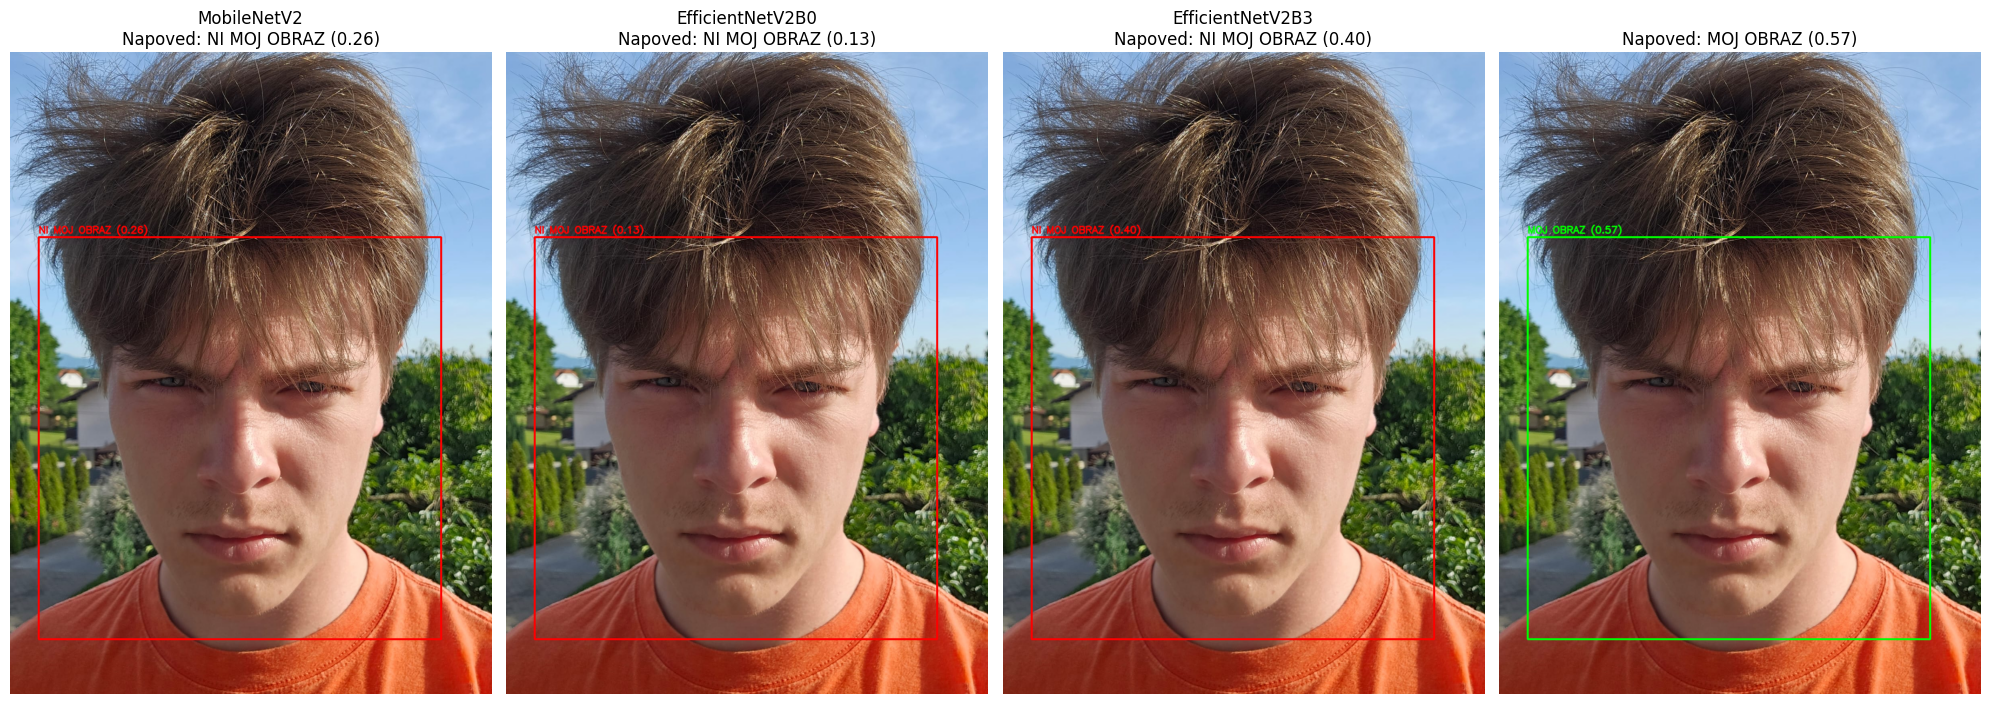


Obdelujem sliko: face_214_aug_2_cleaned_frame_0310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


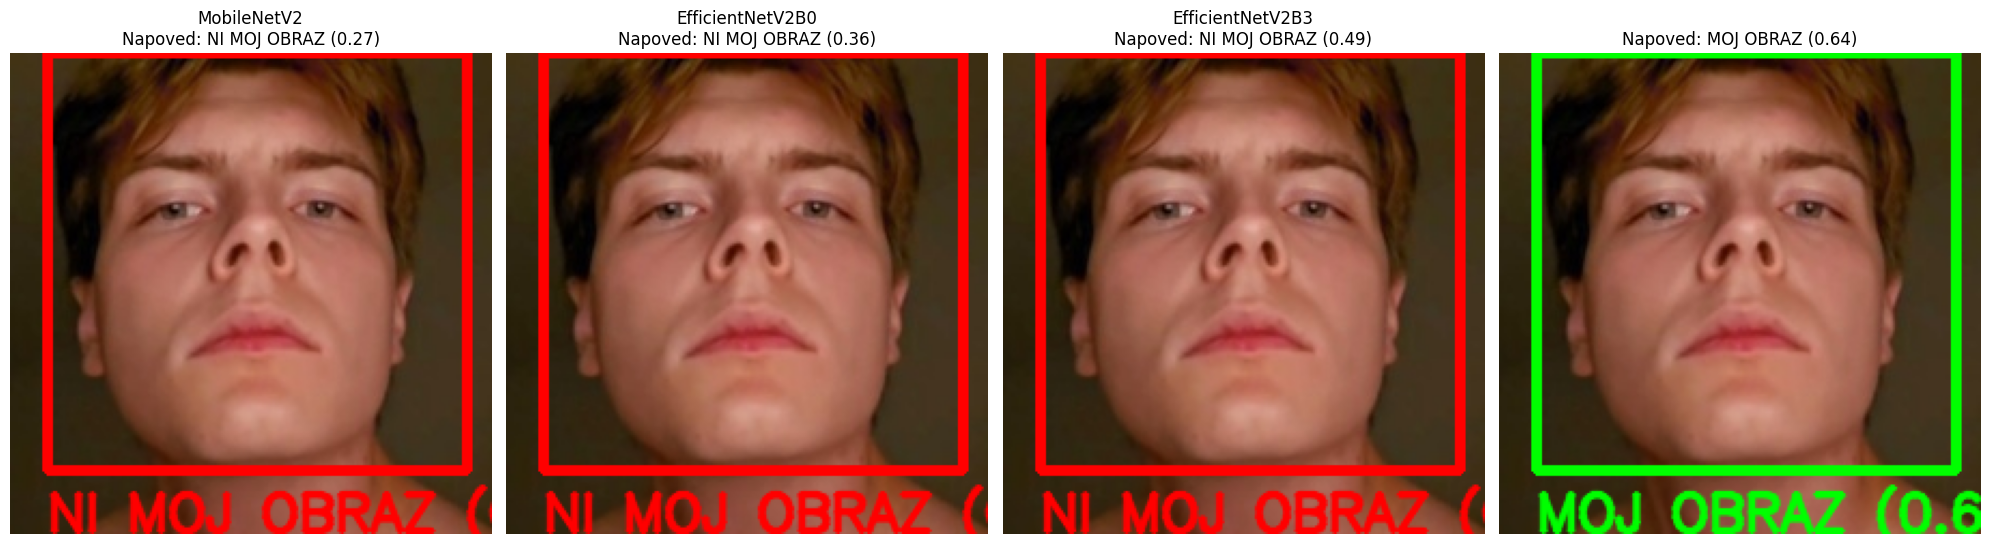


Obdelujem sliko: vitoFaks.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


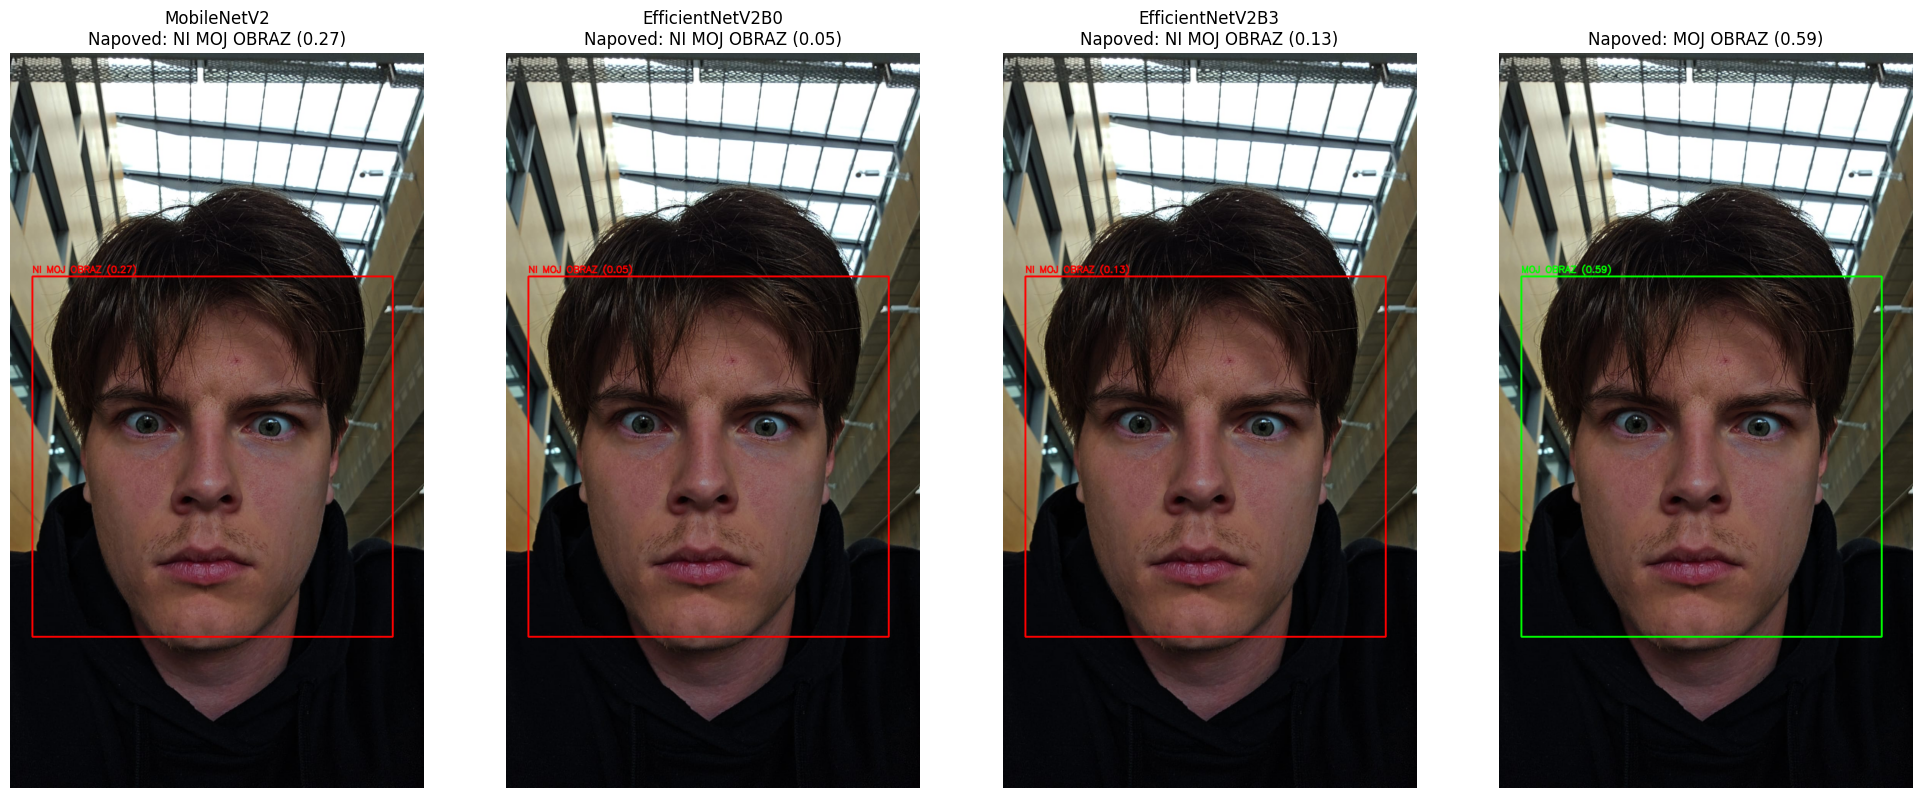


Obdelujem sliko: vitoDoma.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


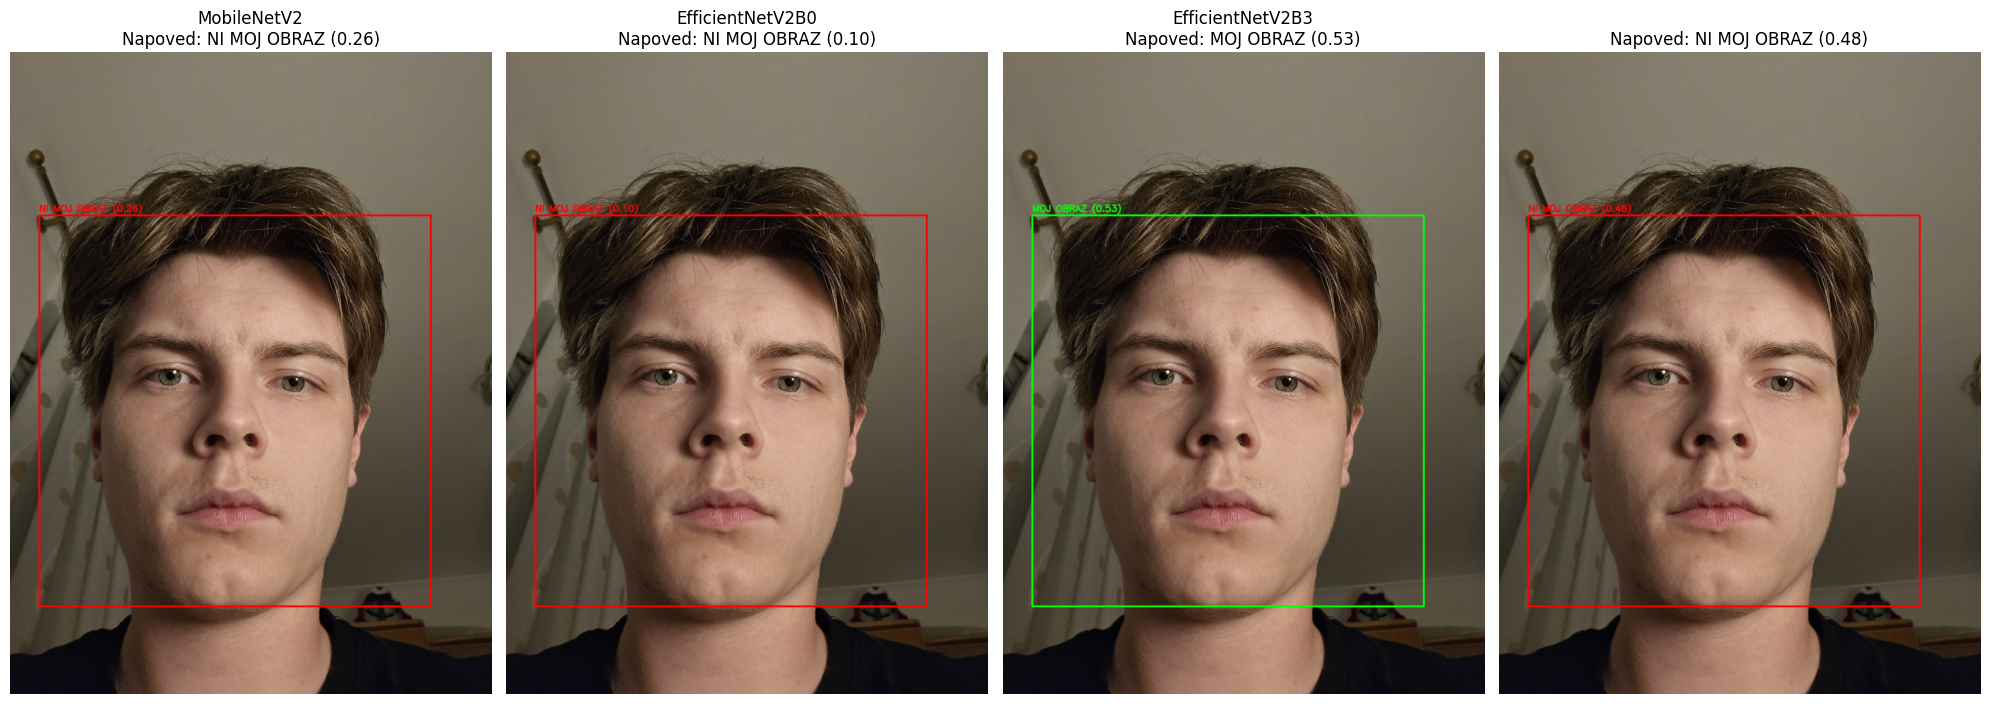


Obdelujem sliko: Image from WhatsApp (5).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


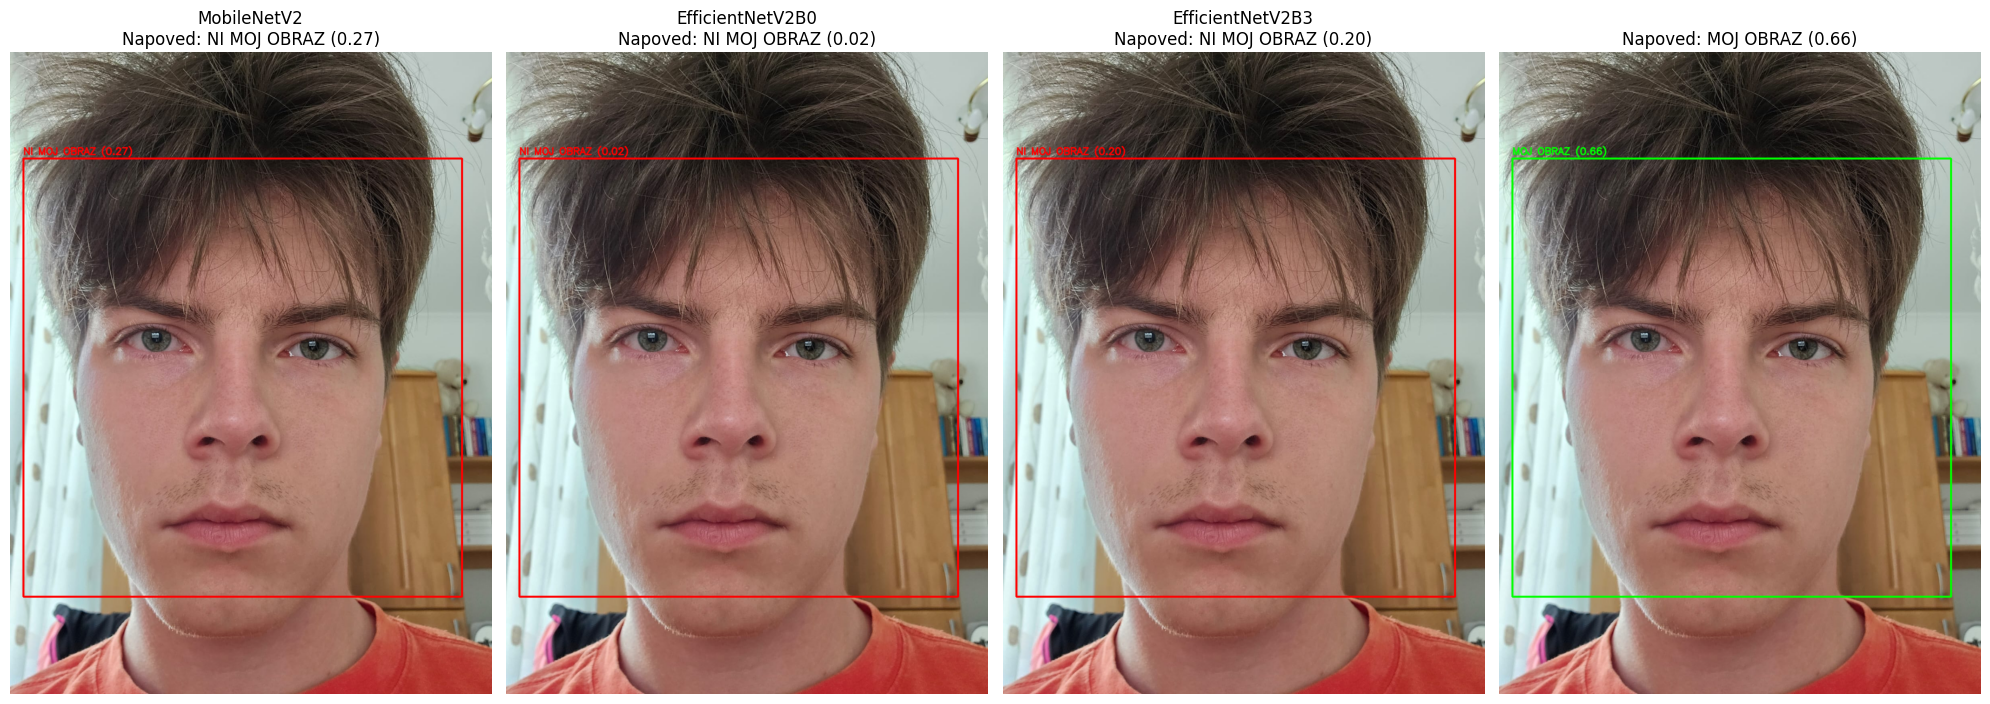

In [34]:
print("\n--- TESTIRANJE NA VSEH SLIKAH V 'RAW_IMAGES_DIR' ---")

RAW_IMAGES_DIR = '../data/raw/slike/' 

# Zbiranje modelov v slovar za lažjo iteracijo
# Prepričaj se, da so te spremenljivke modelov globalno dostopne ali jih posreduj v ta blok
# model_mobilenet, model_efficientnet, model_efficientnet_b3, model_resnet50v2
# Predpostavljam, da so modeli že trenirani in naloženi.
models_to_test = {
    "MobileNetV2": {"model": model_mobilenet, "type": "mobilenet"},
    "EfficientNetV2B0": {"model": model_efficientnet, "type": "efficientnet"},
    "EfficientNetV2B3": {"model": model_efficientnet_b3, "type": "efficientnet"},
    " ": {"model": model_resnet50v2, "type": "resnet"}
}

# Filtriramo modele, ki dejansko obstajajo in so bili trenirani
active_models = {name: data for name, data in models_to_test.items() if data["model"] is not None}

if not active_models:
    print("Noben model ni bil treniran ali naložen. Vizualizacija ni mogoča.")
elif not os.path.exists(RAW_IMAGES_DIR):
    print(f"Napaka: Mapa '{RAW_IMAGES_DIR}' ne obstaja. Prosim, preverite pot.")
else:
    all_raw_images_in_dir = [f for f in os.listdir(RAW_IMAGES_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not all_raw_images_in_dir:
        print(f"Opozorilo: V mapi '{RAW_IMAGES_DIR}' ni bilo najdenih slik za testiranje.")
    else:
        num_models = len(active_models)
        
        for image_filename in all_raw_images_in_dir:
            image_path = os.path.join(RAW_IMAGES_DIR, image_filename)
            print(f"\nObdelujem sliko: {image_filename}")

            plt.figure(figsize=(num_models * 5, 8)) # Prilagodi velikost figure glede na št. modelov
            
            # Shranimo originalno sliko in bbox le enkrat
            original_img_for_all, cropped_face_img, _, bbox = preprocess_for_prediction_full(image_path, IMG_SIZE, model_type='efficientnet') # Uporabimo efficientnet za začetno obdelavo, ker ima najmanj sprememb

            if bbox is None: # Če ni zaznanega obraza, prikažemo samo eno sporočilo
                print(f"Ni zaznanega obraza na sliki {image_filename}. Prikazujem originalno sliko (za vse modele).")
                ax = plt.subplot(1, 1, 1) # Samo en subplot
                ax.imshow(cv2.cvtColor(original_img_for_all, cv2.COLOR_BGR2RGB))
                ax.set_title(f"Ni zaznanega obraza na '{image_filename}'")
                ax.axis('off')
                plt.tight_layout()
                plt.show()
                continue # Preskoči na naslednjo sliko

            # Pripravimo podobe za posamezne modele
            for i, (model_name, model_data) in enumerate(active_models.items()):
                current_model = model_data["model"]
                model_type = model_data["type"]

                # Vsak model potrebuje svojo predprocesirano sliko
                # Tukaj je pomembno, da je obrezovanje enako za vse, samo preprocessing je specifičen za model
                _, _, processed_img_for_model, _ = preprocess_for_prediction_full(image_path, IMG_SIZE, model_type=model_type)
                
                if processed_img_for_model is not None:
                    prediction_prob = current_model.predict(processed_img_for_model)[0][0]
                    
                    ax = plt.subplot(1, num_models, i + 1) # 1 vrstica, num_models stolpcev
                    display_full_image_prediction_multiple_models(ax, model_name, original_img_for_all, bbox, prediction_prob, image_filename)
                else:
                    # To se ne bi smelo zgoditi, če je bil bbox zaznan zgoraj,
                    # ampak za vsak slučaj, če bi se kje zalomilo pri posameznem preprocessingu.
                    ax = plt.subplot(1, num_models, i + 1)
                    ax.imshow(cv2.cvtColor(original_img_for_all, cv2.COLOR_BGR2RGB))
                    ax.set_title(f"{model_name}\nNAPAKA: Obraza ni bilo mogoče predprocesirati.")
                    ax.axis('off')
            
            plt.tight_layout() # Prilagodi postavitev, da se naslovi ne prekrivajo
            plt.show()